In [7]:
import h5py as h5
import pandas as pd
import numpy as np
import cogsworth

import astropy.units as u
import astropy.constants as const

pd.options.display.max_columns = None

In [4]:
def _get_porb_from_a(a, m1, m2):
    """Calculate the orbital period based on the semi-major axis and stellar masses.

    Parameters
    ----------
    a : `float`
        Semi-major axis in solar radii
    m1 : `float`
        Mass of the first star in solar masses
    m2 : `float`
        Mass of the second star in solar masses

    Returns
    =======
    porb : `float`
        Orbital period in days
    """
    return (2 * np.pi * np.sqrt((a * u.Rsun)**3 / (const.G * (m1 + m2) * u.M_sun))).to(u.day).value


def _calculate_roche_lobe_factor(q):
    """Apply Eggleton approximation to calculate the Roche Lobe factor for a star in the binary

    Parameters
    ----------
    q : `float`
        Mass ratio of the binary system (m2/m1 if you want r1 and vice/versa)

    """
    return (0.49 * q**(2/3)) / (0.6 * q**(2/3) + np.log(1 + q**(1/3)))


In [5]:
p = cogsworth.pop.Population(1000, final_kstar1=[13, 14], BSE_settings={"sigma": 20})
p.perform_stellar_evolution()
p.perform_galactic_evolution()

cogsworth warning: Initial binaries not yet sampled, performing sampling now.


1012 1012 1012


1076it [00:06, 159.58it/s]                         


In [6]:
p.bpp[((p.bpp["kstar_1"].isin([13, 14])) & (p.bpp["kstar_2"].isin([13, 14])) & (p.bpp["sep"] > 0))]["bin_num"].unique()

array([ 78,  79, 259, 461, 481, 486, 516, 572, 575, 671, 714, 718, 925])

In [8]:
def create_bpp_from_COMPAS_files(filename):
    """Create a COSMIC-like bpp table from a COMPAS output file

    Parameters
    ----------
    filename : `str`
        Path to the COMPAS output file in HDF5 format.

    Returns
    -------

    bpp : `pandas.DataFrame`
        A DataFrame containing the bpp table with rows for each stellar evolution event.
    """
    BPP_COLUMNS = ["Time", "Mass(1)", "Mass(2)", "Stellar_Type(1)", "Stellar_Type(2)",
                   "SemiMajorAxis", "Eccentricity", "RLOF(1)", "RLOF(2)", "Radius(1)", "Radius(2)"]
    
    # open the COMPAS file
    with h5.File(filename, "r") as f:

        # create a DF just with the moments where a star changes stellar type
        df_dict = {k: f["BSE_Switch_Log"][k][...] for k in f["BSE_Switch_Log"].keys()}
        switch_df = pd.DataFrame(df_dict)
        switch_df.set_index("SEED", inplace=True)

        # but remove any rows where the stellar type doesn't actually change, or mergers
        switch_df = switch_df[(switch_df["Switching_From"] != switch_df["Switching_To"])
                              & (switch_df["Switching_To"] != 15)]
        switch_df = switch_df.loc[:, BPP_COLUMNS]
        switch_df["evol_type"] = 2

        # create a DF with the moments where a star fills its Roche lobe
        df_dict = {k: f["BSE_RLOF"][k][...] for k in f["BSE_RLOF"].keys()}
        rlof_df = pd.DataFrame(df_dict)
        rlof_df.set_index("SEED", inplace=True)

        # convert the DF into two, with a row for the start and end of RLOF
        mt_cols = ["Time", "Mass(1)", "Mass(2)", "Stellar_Type(1)", "Stellar_Type(2)",
                "SemiMajorAxis", "Eccentricity", "Radius(1)", "Radius(2)"]
        start_cols = [c + "<MT" for c in mt_cols]
        end_cols = [c + ">MT" for c in mt_cols] + ["CEE>MT"]
        mt_start_rows = rlof_df[start_cols].rename({s: s.replace("<MT", "") for s in start_cols}, axis=1)
        mt_start_rows["evol_type"] = 3
        mt_end_rows = rlof_df[end_cols].rename({s: s.replace(">MT", "") for s in end_cols if s != "CEE>MT"},
                                               axis=1)
        mt_end_rows["evol_type"] = 4
        # mt_end_rows = mt_end_rows[~mt_end_rows["CEE>MT"] == 1]
        mt_end_rows.drop(columns=["CEE>MT"], inplace=True)

        # combine the mass transfer start and end rows into a single dataframe
        mt_rows = pd.concat([mt_start_rows, mt_end_rows]).sort_values(["SEED", "Time", "evol_type"],
                                                                    ascending=[True, True, False])

        # go through mt_rows dataframe, merge subsequent mass transfer episodes
        mt_rows["SEED"] = mt_rows.index
        for col in ["evol_type", "SEED", "Time"]:
            for prefix, dir in [("prev_", 1), ("next_", -1)]:
                mt_rows[f"{prefix}{col}"] = mt_rows[col].shift(dir)


        mt_rows = mt_rows[~(((mt_rows["evol_type"] == 4) & (mt_rows["next_evol_type"] == 3)
                            & (mt_rows["next_SEED"] == mt_rows["SEED"]) & (mt_rows["next_Time"] == mt_rows["Time"]))
                            | ((mt_rows["evol_type"] == 3) & (mt_rows["prev_evol_type"] == 4)
                            & (mt_rows["prev_SEED"] == mt_rows["SEED"]) & (mt_rows["prev_Time"] == mt_rows["Time"])))]

        # get rid of those extra columns
        mt_rows = mt_rows.loc[:, mt_cols + ["evol_type"]]

        # create a DF with the moments where a star causes a common-envelope event
        df_dict = {k: f["BSE_Common_Envelopes"][k][...] for k in f["BSE_Common_Envelopes"].keys()}
        ce_df = pd.DataFrame(df_dict)
        ce_df.set_index("SEED", inplace=True)

        # as before, convert the DF into two, with a row for the start and end of CE
        ce_cols = ["Time", "Mass(1)", "Mass(2)", "Stellar_Type(1)", "Stellar_Type(2)", "SemiMajorAxis",
                   "Eccentricity", "Radius(1)", "Radius(2)"]
        start_cols = [c + "<CE" if c != "Time" else c for c in ce_cols]
        end_cols = [c + ">CE" if c not in ["Time", "Stellar_Type(1)", "Stellar_Type(2)"] else c for c in ce_cols]
        ce_start_rows = ce_df[start_cols].rename({s: s.replace("<CE", "") for s in start_cols}, axis=1)
        ce_start_rows["evol_type"] = 7
        ce_end_rows = ce_df[end_cols + ["Merger"]].rename({s: s.replace(">CE", "") for s in end_cols}, axis=1)

        # set to -42 so that sorting works out nicely (this is just a magic negative number)
        ce_end_rows["evol_type"] = 6.9

        # if a merger occurs, turn the other star into a massless remnant (COMPAS doesn't do this...?)
        ce_end_rows.loc[(ce_end_rows["Merger"] == 1) & (ce_end_rows["Mass(1)"] > 1e10),
                        ["Mass(1)", "Stellar_Type(1)", "Radius(1)"]] = [0.0, 15, 0.0]
        ce_end_rows.loc[(ce_end_rows["Merger"] == 1) & (ce_end_rows["Mass(2)"] > 1e10),
                        ["Mass(2)", "Stellar_Type(2)", "Radius(2)"]] = [0.0, 15, 0.0]
        ce_end_rows.drop(columns=["Merger"], inplace=True)

        # combine all ce_rows
        ce_rows = pd.concat([ce_start_rows, ce_end_rows]).sort_values(["SEED", "Time"])

        df_dict = {k: f["BSE_Supernovae"][k][...] for k in f["BSE_Supernovae"].keys()}
        sn_df = pd.DataFrame(df_dict)
        sn_df[["RLOF(1)", "RLOF(2)"]] = [0.0, 0.0]
        sn_df.set_index("SEED", inplace=True)
        sn_type = sn_df["Supernova_State"].copy()
        sn_df = sn_df.loc[:, BPP_COLUMNS]
        sn_df["evol_type"] = np.where(sn_type == 1, 15, 16)

        disruption_rows = sn_df.loc[sn_df["SemiMajorAxis"] < 0.0].copy()
        disruption_rows["evol_type"] = 11
        sn_df = pd.concat([sn_df, disruption_rows])

    bpp = pd.concat([switch_df, mt_rows,
                        ce_rows, sn_df], sort=False).sort_values(["SEED", "Time", "evol_type"],
                                                                ascending=[True, True, False])
    # change CE end rows back to evol_type 8
    bpp["evol_type"] = bpp["evol_type"].replace({6.9: 8}).astype(int)

    # find all rows where evol_type == 4 and the previous row had evol_type == 8
    bpp["prev_evol_type"] = bpp["evol_type"].shift(1)
    mask = (bpp["evol_type"] == 4) & (bpp["prev_evol_type"] == 8)
    cols = BPP_COLUMNS + ["row_inds"]
    bpp["row_inds"] = np.arange(len(bpp))
    bpp.loc[mask, cols] = bpp.loc[bpp["row_inds"].isin(bpp.loc[mask, cols]["row_inds"] - 1), cols]

    cols = BPP_COLUMNS + ["evol_type", "bin_num"]
    bpp["bin_num"] = bpp.index
    bpp.index = bpp["bin_num"]
    bpp = bpp.loc[:, cols]

    # calculate porb and match SemiMajorAxis conventions
    merged = bpp["SemiMajorAxis"] == np.inf
    disrupted = bpp["SemiMajorAxis"] < 0.0
    bpp["porb"] = _get_porb_from_a(bpp["SemiMajorAxis"].values, bpp["Mass(1)"].values, bpp["Mass(2)"].values)
    bpp.loc[disrupted, ["SemiMajorAxis", "porb"]] = [-1.0, -1.0]
    bpp.loc[merged, ["SemiMajorAxis", "porb"]] = [0.0, 0.0]

    bpp.rename({
        "Time": "tphys",
        "Mass(1)": "mass_1",
        "Mass(2)": "mass_2",
        "Stellar_Type(1)": "kstar_1",
        "Stellar_Type(2)": "kstar_2",
        "SemiMajorAxis": "sep",
        "Eccentricity": "ecc",
        "RLOF(1)": "RRLO_1",
        "RLOF(2)": "RRLO_2",
        "Radius(1)": "rad_1",
        "Radius(2)": "rad_2",
    }, axis=1, inplace=True)

    bound = bpp["sep"] > 0.0
    bpp.loc[~bound, ["RRLO_1", "RRLO_2"]] = [0.0, 0.0]
    for l, r in [("1", "2"), ("2", "1")]:
        f_Roche = _calculate_roche_lobe_factor(bpp.loc[bound, f"mass_{r}"] / bpp.loc[bound, f"mass_{l}"])
        bpp.loc[bound, f"RRLO_{l}"] = bpp.loc[bound, f"rad_{l}"] / (f_Roche * bpp.loc[bound, "sep"])

    return bpp

In [9]:
bpp = create_bpp_from_COMPAS_files("COMPAS_Output_9/COMPAS_Output.h5")

/home/tom/miniconda3/envs/cogsworth/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [239]:
ce_df.loc[[1751172525]]

,BE_Fixed(1),BE_Fixed(2),BE_Kruckow(1),BE_Kruckow(2),BE_Loveridge(1),BE_Loveridge(2),BE_Loveridge_Winds(1),BE_Loveridge_Winds(2),BE_Nanjing(1),BE_Nanjing(2),Binding_Energy<CE(1),Binding_Energy<CE(2),CE_Event_Counter,Double_Core_CE,Eccentricity<CE,Eccentricity>CE,Immediate_RLOF>CE,Lambda@CE(1),Lambda@CE(2),Lambda_Fixed(1),Lambda_Fixed(2),Lambda_Kruckow(1),Lambda_Kruckow(2),Lambda_Loveridge(1),Lambda_Loveridge(2),Lambda_Loveridge_Winds(1),Lambda_Loveridge_Winds(2),Lambda_Nanjing(1),Lambda_Nanjing(2),Luminosity<CE(1),Luminosity<CE(2),MT_History,Mass(1)<CE,Mass(1)>CE,Mass(2)<CE,Mass(2)>CE,Mass_Env(1),Mass_Env(2),Merger,Optimistic_CE,RLOF(1),RLOF(2),Radius(1)<CE,Radius(1)>CE,Radius(2)<CE,Radius(2)>CE,Record_Type,RocheLobe(1)<CE,RocheLobe(1)>CE,RocheLobe(2)<CE,RocheLobe(2)>CE,SemiMajorAxis<CE,SemiMajorAxis>CE,Simultaneous_RLOF,Stellar_Type(1),Stellar_Type(1)<CE,Stellar_Type(2),Stellar_Type(2)<CE,Tau_Circ,Tau_Dynamical<CE(1),Tau_Dynamical<CE(2),Tau_Radial<CE(1),Tau_Radial<CE(2),Tau_Sync,Tau_Thermal<CE(1),Tau_Thermal<CE(2),Teff<CE(1),Teff<CE(2),Time,Zeta_Lobe,Zeta_Star
SEED,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1751172525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0,1.0,1.0,0.1,0.1,8.614542,12.297583,0.0,0.0,0.0,0.0,1.0,1.0,873.136445,62.978142,6,5.38766,6.653403e+246,2.739542,3.196672,0.0,0.0,1,0,1,0,3.164038,1.800923e+219,1.85507,2.62165,1,3.145517,0.0,2.310845,0.0,7.173257,0.0,0,1,1,1,1,0.0,1.212363e-10,7.632583e-11,143.319678,944.222876,0.0,0.329918,2.017137,17657.418155,11950.740932,30.782788,2.356731,2.0


In [243]:
bpp.loc[1751172534]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,ecc,RRLO_1,RRLO_2,rad_1,rad_2,evol_type,bin_num,porb
bin_num,,,,,,,,,,,,,,
1751172534,47.192655,6.285455e+00,2.702719e+00,1,1,10.787041,0.0,1.47372,0.382639,4.908062e+00,1.871578,3,1751172534,1.368866
1751172534,47.811058,6.285455e+00,2.702719e+00,1,1,10.787041,0.0,1.47372,0.382639,4.908062e+00,1.871578,7,1751172534,1.368866
1751172534,47.811058,6.089408e-154,6.656048e-310,1,1,0.000000,0.0,0.00000,0.000000,4.047386e-320,0.000000,8,1751172534,0.000000
1751172534,47.811058,6.089408e-154,6.656048e-310,1,1,0.000000,0.0,0.00000,0.000000,4.047386e-320,0.000000,4,1751172534,0.000000
1751172534,78.385656,8.354768e+00,0.000000e+00,2,15,0.000000,0.0,0.00000,0.000000,7.946951e+00,0.000000,2,1751172534,0.000000
1751172534,78.487748,8.353066e+00,0.000000e+00,3,15,0.000000,0.0,0.00000,0.000000,1.332056e+02,0.000000,2,1751172534,0.000000
1751172534,78.507967,8.351680e+00,0.000000e+00,4,15,0.000000,0.0,0.00000,0.000000,2.642565e+02,0.000000,2,1751172534,0.000000
1751172534,82.514031,7.955634e+00,0.000000e+00,5,15,0.000000,0.0,0.00000,0.000000,2.519832e+02,0.000000,2,1751172534,0.000000
1751172534,82.656071,1.187192e+00,0.000000e+00,13,15,NaN,NaN,0.00000,0.000000,1.437401e-05,0.000000,15,1751172534,NaN


In [11]:
from importlib import reload
reload(cogsworth)

<module 'cogsworth' from '/home/tom/Documents/research/cogsworth/cogsworth/__init__.py'>

In [21]:
df = p.initC[["kstar_1", "kstar_2", "mass_1", "mass_2", "porb", "ecc", "metallicity"]]
df

,kstar_1,kstar_2,mass_1,mass_2,porb,ecc,metallicity
0,1.0,1.0,4.957320,4.377241,237392.843796,0.182892,0.014062
1,1.0,1.0,3.885284,3.729333,3952.726512,0.249346,0.001775
2,1.0,1.0,3.917901,2.774863,91929.293632,0.019625,0.009402
3,1.0,1.0,24.791679,4.613200,24.701426,0.728437,0.001527
4,1.0,1.0,26.319454,7.530541,66.359957,0.141209,0.008864
...,...,...,...,...,...,...,...
1007,1.0,1.0,8.785254,6.754277,15.501386,0.108903,0.001586
1008,1.0,1.0,11.296831,5.671765,432.883016,0.504264,0.005370
1009,1.0,1.0,10.494430,6.580010,63.242490,0.666579,0.026702
1010,1.0,1.0,8.429491,6.803597,27.606868,0.022057,0.006096


In [32]:
df

,kstar_1,kstar_2,mass_1,mass_2,porb,ecc,metallicity
0,1.0,1.0,4.957320,4.377241,237392.843796,0.182892,0.014062
1,1.0,1.0,3.885284,3.729333,3952.726512,0.249346,0.001775
2,1.0,1.0,3.917901,2.774863,91929.293632,0.019625,0.009402
3,1.0,1.0,24.791679,4.613200,24.701426,0.728437,0.001527
4,1.0,1.0,26.319454,7.530541,66.359957,0.141209,0.008864
...,...,...,...,...,...,...,...
1007,1.0,1.0,8.785254,6.754277,15.501386,0.108903,0.001586
1008,1.0,1.0,11.296831,5.671765,432.883016,0.504264,0.005370
1009,1.0,1.0,10.494430,6.580010,63.242490,0.666579,0.026702
1010,1.0,1.0,8.429491,6.803597,27.606868,0.022057,0.006096


In [ ]:
def stringify_initC(df):
    return " ".join([f'--stellar-type-1 {df["mass_1"]}',
                     f'--stellar-type-2 {df["mass_2"]}',
                     f'--initial-mass-1 {df["mass_1"]}',
                     f'--initial-mass-2 {df["mass_2"]}',
                     f'--orbital-period {df["porb"]}',
                     f'--eccentricity {df["ecc"]}',
                     f'--metallicity {df["metallicity"]}'])
'\n'.join(df.apply(stringify_initC, axis=1).values)

'--stellar-type-1 4.957319923965197 --stellar-type-2 4.3772410874811785 --initial-mass-1 4.957319923965197 --initial-mass-2 4.3772410874811785 --orbital-period 237392.84379603332 --eccentricity 0.18289155596749662 --metallicity 0.014061838644919167\n--stellar-type-1 3.885283531057645 --stellar-type-2 3.729332527972702 --initial-mass-1 3.885283531057645 --initial-mass-2 3.729332527972702 --orbital-period 3952.726511632843 --eccentricity 0.2493456446920373 --metallicity 0.001774680673374684\n--stellar-type-1 3.917900839168092 --stellar-type-2 2.7748629978914736 --initial-mass-1 3.917900839168092 --initial-mass-2 2.7748629978914736 --orbital-period 91929.293632455 --eccentricity 0.019625161455851848 --metallicity 0.009402068372243007\n--stellar-type-1 24.791679304802898 --stellar-type-2 4.613199906507875 --initial-mass-1 24.791679304802898 --initial-mass-2 4.613199906507875 --orbital-period 24.70142608681611 --eccentricity 0.7284365906725095 --metallicity 0.0015274612785086679\n--stellar-

0        --initial-mass-1 4.957319923965197
1        --initial-mass-1 3.885283531057645
2        --initial-mass-1 3.917900839168092
3       --initial-mass-1 24.791679304802898
4        --initial-mass-1 26.31945378628817
                       ...                 
1007      --initial-mass-1 8.78525372312111
1008    --initial-mass-1 11.296830582584507
1009    --initial-mass-1 10.494430198174596
1010     --initial-mass-1 8.429490502409742
1011    --initial-mass-1 12.202036881699392
Length: 1012, dtype: object

                tphys         mass_1         mass_2  kstar_1  kstar_2  \
bin_num                                                                 
1751172534  47.192655   6.285455e+00   2.702719e+00        1        1   
1751172534  47.811058   6.285455e+00   2.702719e+00        1        1   
1751172534  47.811058  6.089408e-154  6.656048e-310        1        1   
1751172534  78.385656   8.354768e+00   0.000000e+00        2       15   
1751172534  78.487748   8.353066e+00   0.000000e+00        3       15   
1751172534  78.507967   8.351680e+00   0.000000e+00        4       15   
1751172534  82.514031   7.955634e+00   0.000000e+00        5       15   
1751172534  82.656071   1.187192e+00   0.000000e+00       13       15   
1751172534  82.656071   1.187192e+00   0.000000e+00       13       15   

                porb        sep  evol_type   RRLO_1    RRLO_2  prev_kstar_1  \
bin_num                                                                       
1751172534  1.368866  10.787041       

/home/tom/Documents/research/cogsworth/cogsworth/plot.py:285: RuntimeWarning: invalid value encountered in scalar divide
  sep_modifier = (np.log10(row["sep"]) - min_log10_sep) / (max_log10_sep - min_log10_sep)


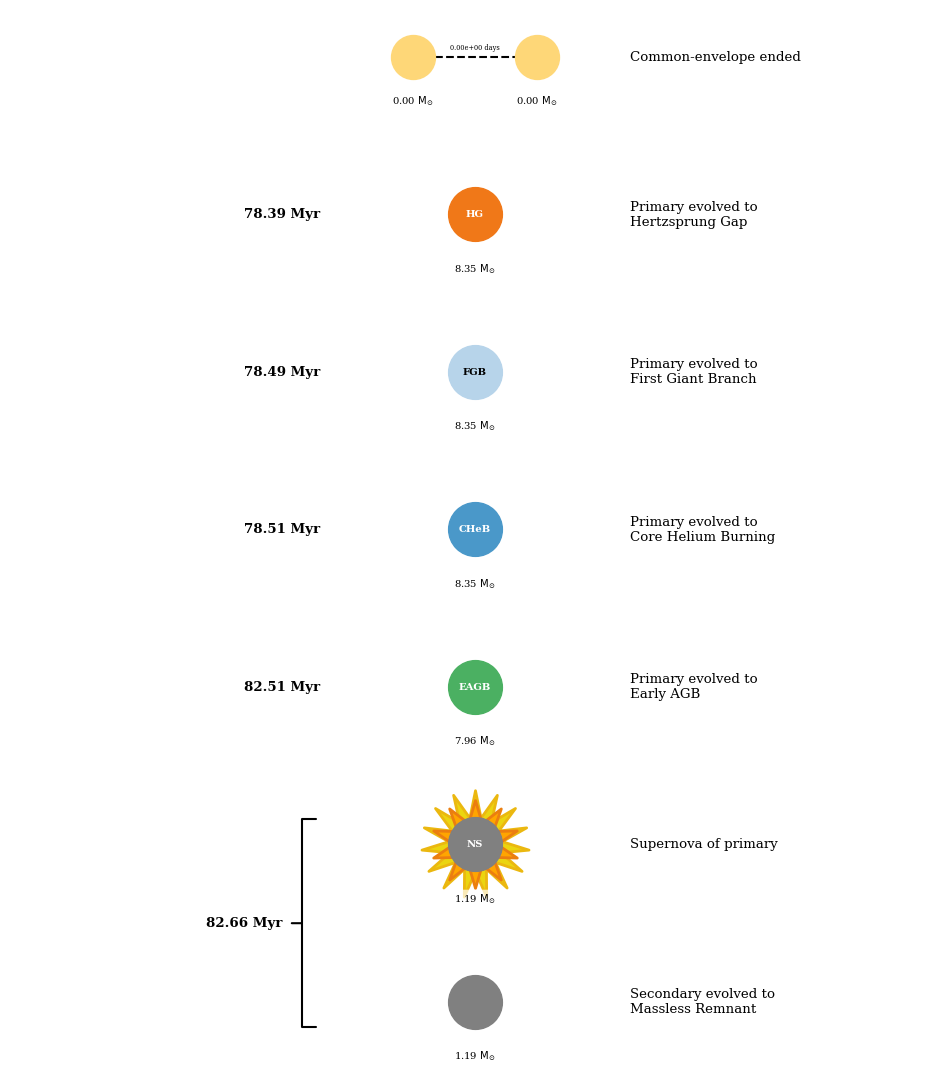

(<Figure size 1200x1350 with 1 Axes>, <Axes: >)

In [12]:
cogsworth.plot.plot_cartoon_evolution(bpp, 1751172534)

In [221]:
bpp.loc[bpp["bin_num"].unique()[7]]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,ecc,RRLO_1,RRLO_2,rad_1,rad_2,evol_type,bin_num,porb
bin_num,,,,,,,,,,,,,,
1751172532,12.917543,15.056898,7.400171,2,1,9618.881615,0.000000,3.837511e-03,0.000862,11.789985,3.659581,2,1751172532,23059.699845
1751172532,12.943713,15.041492,7.400155,4,1,9625.491782,0.000000,2.329272e-02,0.000862,71.629847,3.660805,2,1751172532,23091.404329
1751172532,14.347201,13.601906,7.399290,5,1,10285.694204,0.000000,1.992608e-01,0.000838,671.485300,3.728072,2,1751172532,26367.667147
1751172532,14.399476,2.729690,7.399257,14,1,-1.000000,9.757824,0.000000e+00,0.000000,0.000012,3.730642,15,1751172532,-1.000000
1751172532,14.399476,2.729690,7.399258,14,1,10395.009965,0.000000,2.383832e-09,0.001209,0.000012,3.730642,2,1751172532,38574.339731
1751172532,44.195786,2.729690,7.360307,14,2,-1.000000,9.757824,0.000000e+00,0.000000,0.000012,7.347559,2,1751172532,-1.000000
1751172532,44.338569,2.729690,7.359325,14,3,-1.000000,9.757824,0.000000e+00,0.000000,0.000012,103.656808,2,1751172532,-1.000000
1751172532,44.375730,2.729690,7.358055,14,4,-1.000000,9.757824,0.000000e+00,0.000000,0.000012,212.040071,2,1751172532,-1.000000
1751172532,49.693376,2.729690,7.139965,14,5,-1.000000,9.757824,0.000000e+00,0.000000,0.000012,194.457088,2,1751172532,-1.000000


In [210]:
bpp[bpp["kstar_1"].isin([13, 14])]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,ecc,RRLO_1,RRLO_2,rad_1,rad_2,evol_type,bin_num,porb
bin_num,,,,,,,,,,,,,,
1751172525,76.801166,1.260000,0.000000,13,15,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000014,0.000000,2,1751172525,0.000000
1751172527,35.805456,1.198622,3.539689,13,1,8736.499810,0.000000,3.466163e-09,8.816502e-04,0.000014,2.235129,2,1751172527,43454.802263
1751172527,237.076535,1.198622,3.538661,13,2,-1.000000,78.455767,0.000000e+00,0.000000e+00,0.000014,4.812631,2,1751172527,-1.000000
1751172527,238.361290,1.198622,3.538435,13,3,-1.000000,78.455767,0.000000e+00,0.000000e+00,0.000014,21.022951,2,1751172527,-1.000000
1751172527,239.394451,1.198622,3.537417,13,4,-1.000000,78.455767,0.000000e+00,0.000000e+00,0.000014,55.467818,2,1751172527,-1.000000
1751172527,286.951856,1.198622,3.502620,13,5,-1.000000,78.455767,0.000000e+00,0.000000e+00,0.000014,39.426548,2,1751172527,-1.000000
1751172527,288.999677,1.198622,3.462598,13,6,-1.000000,78.455767,0.000000e+00,0.000000e+00,0.000014,312.110306,2,1751172527,-1.000000
1751172527,289.589677,1.198622,0.738073,13,11,-1.000000,78.455767,0.000000e+00,0.000000e+00,0.000014,0.011036,2,1751172527,-1.000000
1751172528,6.735806,11.534062,24.818833,14,1,43847.680071,0.000000,2.497824e-09,1.441367e-03,0.000049,19.902771,2,1751172528,176398.034553


In [229]:
with h5.File("COMPAS_Output_9/COMPAS_Output.h5", "r") as f:
    df_dict = {k: f["BSE_System_Parameters"][k][...] for k in f["BSE_System_Parameters"].keys()}
    sys_df = pd.DataFrame(df_dict)
    sys_df.set_index("SEED", inplace=True)

    # create a DF with the moments where a star causes a common-envelope event
    df_dict = {k: f["BSE_Common_Envelopes"][k][...] for k in f["BSE_Common_Envelopes"].keys()}
    ce_df = pd.DataFrame(df_dict)
    ce_df.set_index("SEED", inplace=True)

    df_dict = {k: f["BSE_Supernovae"][k][...] for k in f["BSE_Supernovae"].keys()}
    sn_df = pd.DataFrame(df_dict)
    sn_df.set_index("SEED", inplace=True)

    df_dict = {k: f["BSE_Switch_Log"][k][...] for k in f["BSE_Switch_Log"].keys()}
    switch_df = pd.DataFrame(df_dict)
    switch_df.set_index("SEED", inplace=True)

In [212]:
BPP_COLUMNS = ["Time", "Mass(1)", "Mass(2)", "Stellar_Type(1)", "Stellar_Type(2)",
                   "SemiMajorAxis", "Eccentricity", "RLOF(1)", "RLOF(2)", "Radius(1)", "Radius(2)"]

In [213]:
sys_df

,CH_on_MS(1),CH_on_MS(2),Eccentricity,Eccentricity@ZAMS,Equilibrated_At_Birth,Error,Evolution_Status,Mass(1),Mass(2),Mass@ZAMS(1),Mass@ZAMS(2),Merger,Merger_At_Birth,Metallicity@ZAMS(1),Metallicity@ZAMS(2),Omega@ZAMS(1),Omega@ZAMS(2),PO_CE_Alpha,PO_LBV_Factor,PO_Sigma_Kick_CCSN_BH,PO_Sigma_Kick_CCSN_NS,PO_Sigma_Kick_ECSN,PO_Sigma_Kick_USSN,PO_WR_Factor,Radius(1),Radius(2),Record_Type,SN_Kick_Magnitude_Random_Number(1),SN_Kick_Magnitude_Random_Number(2),SemiMajorAxis,SemiMajorAxis@ZAMS,Stellar_Type(1),Stellar_Type(2),Stellar_Type@ZAMS(1),Stellar_Type@ZAMS(2),Time,Unbound
SEED,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1751172525,0,0,NaN,0.0,0,42,16,1.260000,0.000000,5.389481,2.739553,1,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,0.000014,0.000000,1,0.195651,0.931547,NaN,0.033352,13,15,1,1,76.801166,1
1751172526,0,0,0.000000,0.0,0,0,12,2.476794,1.837621,11.009024,1.837625,1,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,221.361487,1.500212,1,0.671604,0.682032,1.533168,1.770188,3,1,1,1,21.264795,0
1751172527,0,0,78.455767,0.0,0,42,3,1.198622,0.738073,8.757313,3.539783,0,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,0.000014,0.011036,1,0.069792,0.347458,-262.200116,39.259342,13,11,1,1,14181.658855,1
1751172528,0,0,0.289109,0.0,0,0,14,11.534062,9.500965,30.752137,25.879370,0,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,0.000049,0.000040,1,0.498370,0.254700,121267.527229,191.936544,14,14,1,1,7.805989,0
1751172529,0,0,0.000000,0.0,0,0,3,1.329514,0.176282,7.394945,0.176282,0,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,0.003753,0.208886,1,0.761883,0.812828,59906.196835,55.407493,12,0,1,0,14152.057789,0
1751172530,0,0,0.000000,0.0,0,42,12,0.740735,1.673294,5.003998,1.563574,1,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,0.011004,2.099129,1,0.466601,0.696326,4.614492,0.875581,11,1,1,1,1258.402685,0
1751172531,0,0,0.000000,0.0,0,0,15,0.886162,0.678302,5.327674,2.668682,0,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,0.009333,0.011764,1,0.720500,0.217075,214743.664423,195.384746,11,11,1,1,635.502184,0
1751172532,0,0,9.757824,0.0,0,0,3,2.729690,1.303023,15.223544,7.406715,0,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,0.000012,0.004200,1,0.323102,0.589074,-2276.625379,44.389982,14,12,1,1,14151.893983,1
1751172533,0,0,0.000000,0.0,0,42,12,0.831560,1.265262,7.682147,1.674423,1,0,0.0142,0.0142,0.0,0.0,1.0,1.5,265.0,265.0,30.0,30.0,1.0,1.423778,1.233132,1,0.174719,0.746756,0.151973,0.256836,8,1,1,1,50.046625,0
